In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt 
import seaborn as sns
import osmnx as ox
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import folium

In [3]:
df_05 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202205-divvy-tripdata.csv')
df_06 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202206-divvy-tripdata.csv')
df_07 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202207-divvy-tripdata.csv')
df_08 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202208-divvy-tripdata.csv')
df_09 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202209-divvy-publictripdata.csv')
df_10 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202210-divvy-tripdata.csv')
df_11 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202211-divvy-tripdata.csv')
df_12 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202212-divvy-tripdata.csv')
df_01 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202301-divvy-tripdata.csv')
df_02 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202302-divvy-tripdata.csv')
df_03 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202303-divvy-tripdata.csv')
df_04 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202304-divvy-tripdata.csv')

df = pd.concat([df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_01, df_02, df_03, df_04], ignore_index=True)
df = df.dropna().reset_index()

unique_stations_start = df.groupby('start_station_id').first().reset_index()

# Aggregieren der eindeutigen Endstationen
unique_stations_end = df.groupby('end_station_id').first().reset_index()

# Umbenennen der Spalten, um sie zu vereinheitlichen
unique_stations_start = unique_stations_start.rename(columns={'start_station_id': 'station_id'})
unique_stations_end = unique_stations_end.rename(columns={'end_station_id': 'station_id'})

# Zusammenführen der DataFrames, um eine Liste aller eindeutigen Stationen zu erhalten
unique_stations_master = pd.concat([unique_stations_start[['station_id']], unique_stations_end[['station_id']]]).drop_duplicates().reset_index(drop=True)

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])


df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60


df = df[(df['ride_duration'] >= 5) & (df['ride_duration'] <= 120)]

df_start = df

In [6]:
unique_stations_master

,station_id
0,021320
1,1011
2,1012
3,1013
4,1014
...,...
1307,946
1308,962
1309,981
1310,983


In [18]:
# Berechnung der Gesamttrips je Startstation
total_trips_per_start_station = df.groupby('start_station_id')['ride_id'].count().reset_index(name='total_trips_start')

# Filtern der Startstationen mit weniger als 200 Trips
stations_to_remove_start = total_trips_per_start_station[total_trips_per_start_station['total_trips_start'] < 200]['start_station_id']

# Berechnung der Gesamttrips je Endstation
total_trips_per_end_station = df.groupby('end_station_id')['ride_id'].count().reset_index(name='total_trips_end')

# Filtern der Endstationen mit weniger als 200 Trips
stations_to_remove_end = total_trips_per_end_station[total_trips_per_end_station['total_trips_end'] < 200]['end_station_id']

# Kombinieren der Listen der zu entfernenden Stationen ohne Duplikate
stations_to_remove_combined = pd.concat([stations_to_remove_start, stations_to_remove_end]).drop_duplicates().reset_index(drop=True)

# Entfernen der Stationen mit weniger als 200 Trips aus dem Haupt-DataFrame
df_filtered_combined = df[~df['start_station_id'].isin(stations_to_remove_combined) & ~df['end_station_id'].isin(stations_to_remove_combined)]

# Zusammenführen der Informationen von Start- und Endstationen in einem DataFrame
unique_stations_start = df_filtered_combined.groupby('start_station_id').first().reset_index()[['start_station_id', 'start_lat', 'start_lng']].rename(columns={'start_station_id': 'station_id', 'start_lat': 'lat', 'start_lng': 'lng'})
unique_stations_end = df_filtered_combined.groupby('end_station_id').first().reset_index()[['end_station_id', 'end_lat', 'end_lng']].rename(columns={'end_station_id': 'station_id', 'end_lat': 'lat', 'end_lng': 'lng'})

# Vereinigung der einzigartigen Start- und Endstationen, Duplikate entfernen
unique_stations_combined = pd.concat([unique_stations_start, unique_stations_end]).drop_duplicates().reset_index(drop=True)


In [19]:
unique_stations_combined

,station_id,lat,lng
0,021320,41.890000,-87.680000
1,13001,41.883984,-87.624684
2,13006,41.882465,-87.632288
3,13008,41.881032,-87.624084
4,13011,41.879255,-87.639904
...,...,...,...
792,TA1309000059,41.928887,-87.658971
793,TA1309000064,41.871262,-87.673688
794,TA1309000066,41.969090,-87.674237
795,WL-012,41.883380,-87.641170


In [12]:
unique_stations_start = df.groupby('start_station_id').first().reset_index()
unique_stations_end = df.groupby('end_station_id').first().reset_index()

In [16]:
# Assuming 'unique_stations_start' and 'unique_stations_end' DataFrames have been correctly defined as shown,
# let's calculate how many stations are common in both and how many are unique to each DataFrame.

# Extracting station IDs as sets for easy comparison
start_station_ids = set(unique_stations_start['start_station_id'])
end_station_ids = set(unique_stations_end['end_station_id'])

# Finding common stations in both DataFrames
common_stations = start_station_ids.intersection(end_station_ids)

# Finding stations unique to each DataFrame
unique_to_start = start_station_ids.difference(end_station_ids)
unique_to_end = end_station_ids.difference(start_station_ids)

# Counting the number of stations in each category
num_common_stations = len(common_stations)
num_unique_to_start = len(unique_to_start)
num_unique_to_end = len(unique_to_end)

num_common_stations, num_unique_to_start, num_unique_to_end


(1235, 23, 45)

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

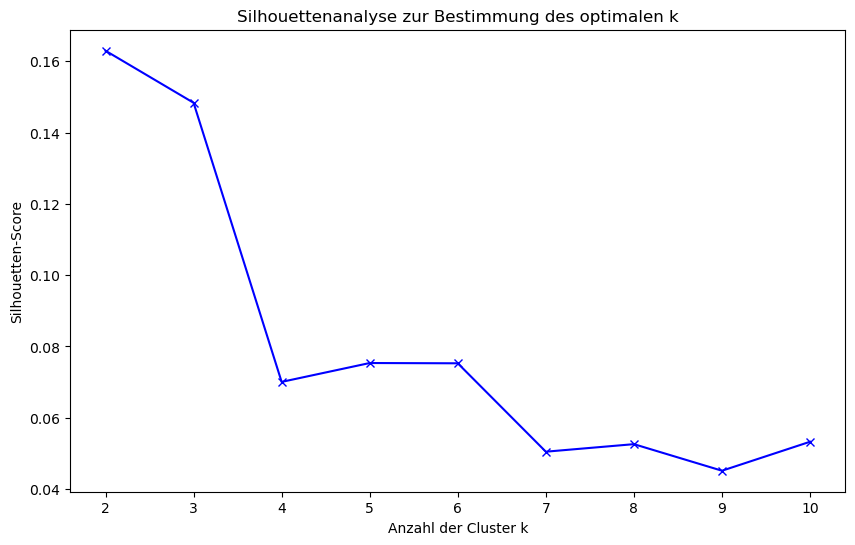

In [24]:
# Voraussetzung: Du hast bereits 'scaled_features_rowwise_start' und 'scaled_features_rowwise_end' berechnet
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_filtered_combined.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise_end = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

df = df_filtered_combined.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['started_at'] = pd.to_datetime(df['started_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='start_station_id', 
                        columns='weekday_hour', 
                        values='ride_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['start_station_id'] + sorted([col for col in pivot_df.columns if col != 'start_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('start_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise_start = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))
# 1. Kombinieren der Features
combined_features = np.vstack([scaled_features_rowwise_start, scaled_features_rowwise_end])

# 2. Bestimmen der optimalen Clusterzahl
silhouette_scores = []
K = range(2, 11)  # Bereich der zu testenden k-Werte
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(combined_features, cluster_labels))

# 3. Silhouetten-Score plotten
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Anzahl der Cluster k')
plt.ylabel('Silhouetten-Score')
plt.title('Silhouettenanalyse zur Bestimmung des optimalen k')
plt.show()


kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters_final = kmeans_final.fit_predict(combined_features)

# 5. Cluster-Zuordnungen den Stationen zuweisen
# Hinweis: Du musst sicherstellen, dass du die Stationen in der gleichen Reihenfolge wie in 'combined_features' behältst
pivot_df_start['cluster'] = clusters_final[:len(scaled_features_rowwise_start)]
pivot_df_end['cluster'] = clusters_final[len(scaled_features_rowwise_start):]

# Jetzt hast du 'pivot_df_start' und 'pivot_df_end' mit den Cluster-Zuordnungen

In [31]:
# Voraussetzung: Du hast bereits 'scaled_features_rowwise_start' und 'scaled_features_rowwise_end' berechnet
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_filtered_combined.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df_end = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns_end = ['end_station_id'] + sorted([col for col in pivot_df_end.columns if col != 'end_station_id'])
pivot_df_end = pivot_df_end[sorted_columns_end]

features = pivot_df_end.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise_end = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

df = df_filtered_combined.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['started_at'] = pd.to_datetime(df['started_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['started_at'].dt.hour
df.loc[:, 'weekday'] = df['started_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df_start = df.pivot_table(index='start_station_id', 
                        columns='weekday_hour', 
                        values='ride_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns_start = ['start_station_id'] + sorted([col for col in pivot_df_start.columns if col != 'start_station_id'])
pivot_df_start = pivot_df_start[sorted_columns_start]

features = pivot_df_start.drop('start_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise_start = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))
# 1. Kombinieren der Features
combined_features = np.vstack([scaled_features_rowwise_start, scaled_features_rowwise_end])



kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(combined_features)

# 5. Cluster-Zuordnungen den Stationen zuweisen
# Hinweis: Du musst sicherstellen, dass du die Stationen in der gleichen Reihenfolge wie in 'combined_features' behältst
pivot_df_start['cluster'] = clusters_final[:len(scaled_features_rowwise_start)]
pivot_df_end['cluster'] = clusters_final[len(scaled_features_rowwise_start):]

# Jetzt hast du 'pivot_df_start' und 'pivot_df_end' mit den Cluster-Zuordnungen

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
# Schritt 2: Vereinheitlichung der Spaltennamen
pivot_df_start = pivot_df_start.rename(columns={'start_station_id': 'station_id'})
pivot_df_end = pivot_df_end.rename(columns={'end_station_id': 'station_id'})

# Schritt 3: Kombinieren der Cluster-Zuweisungen
combined_clusters = pd.concat([pivot_df_start[['station_id', 'cluster']], pivot_df_end[['station_id', 'cluster']]]).drop_duplicates()

# Schritt 4: Zusammenführen mit dem Haupt-DataFrame
# Hinweis: Dieser Schritt hängt davon ab, wie du die Clusterzuweisungen in deinem Haupt-DataFrame verwenden möchtest.
# Wenn dein Haupt-DataFrame 'df' bereits eine 'station_id' Spalte hat, kannst du direkt zusammenführen.
# Andernfalls musst du 'df' so anpassen, dass es eine 'station_id' Spalte gibt oder separate Zusammenführungen für Start- und Endstationen durchführen.

# Beispiel für eine direkte Zusammenführung, wenn 'station_id' vorhanden ist
df_merged = df.merge(combined_clusters, on='station_id', how='left')

# Schritt 5: Zählen der Cluster
cluster_counts_stations = combined_clusters['cluster'].value_counts()
print(cluster_counts_stations)

cluster_counts_df = df_merged['cluster'].value_counts()
print(cluster_counts_df)


KeyError: 'station_id'

In [32]:
# Schritt 2: Vereinheitlichung der Spaltennamen
pivot_df_start = pivot_df_start.rename(columns={'start_station_id': 'station_id'})
pivot_df_end = pivot_df_end.rename(columns={'end_station_id': 'station_id'})

pivot_df = pivot_df_start.merge(pivot_df_end[['station_id', 'cluster']], on='station_id', how='left')
unique_stations = unique_stations_combined.merge(pivot_df[['station_id', 'cluster']], on='station_id', how='left')

# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_stations = unique_stations['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_stations)

KeyError: "['cluster'] not in index"

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_19557/1773383821.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start_specific['start_hour'] = df_start_specific['started_at'].dt.hour
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_19557/1773383821.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start_specific['start_weekday'] = df_start_specific['started_at'].dt.weekday
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_19557/1773383821.py:11: SettingWithCopyWar

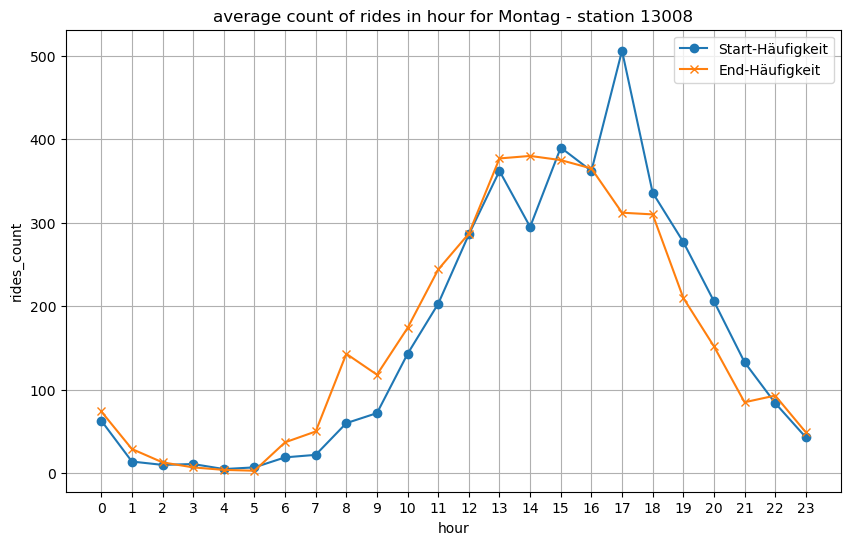

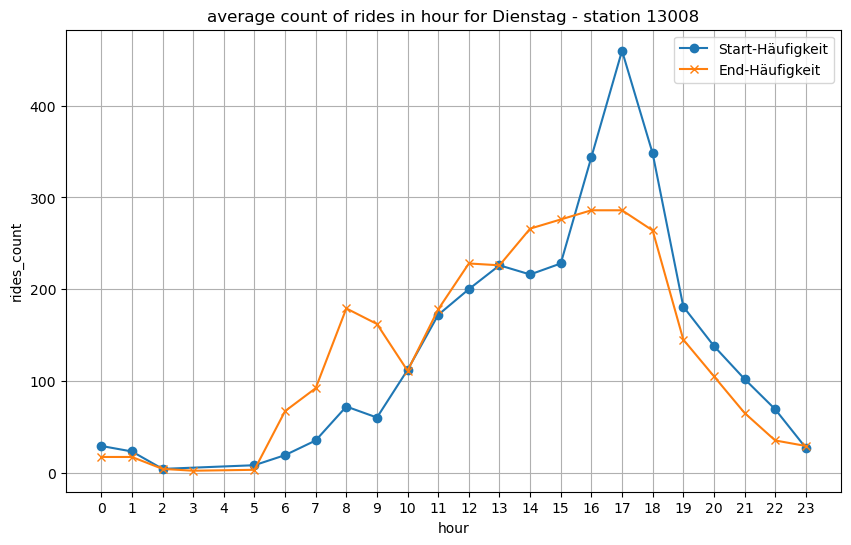

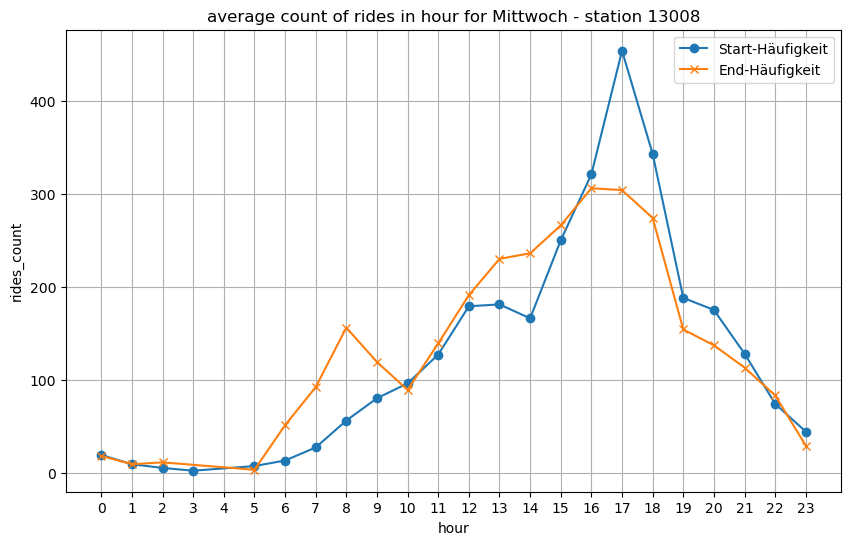

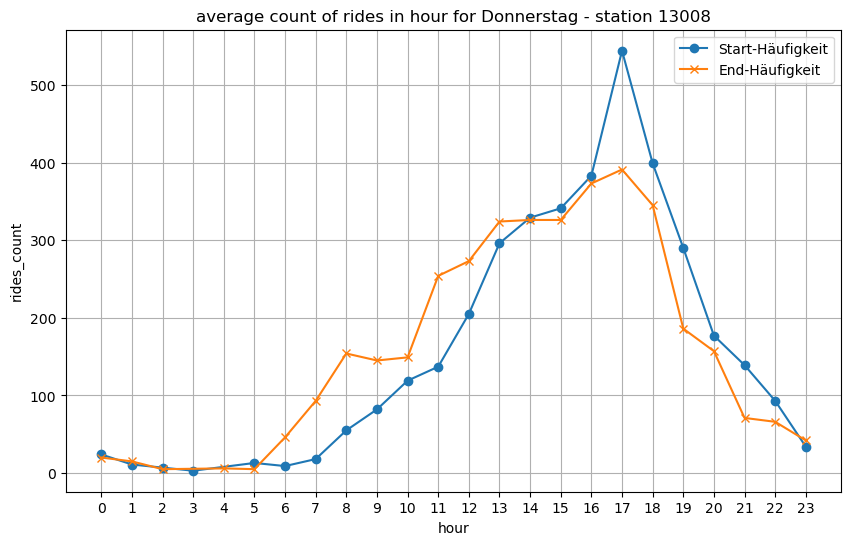

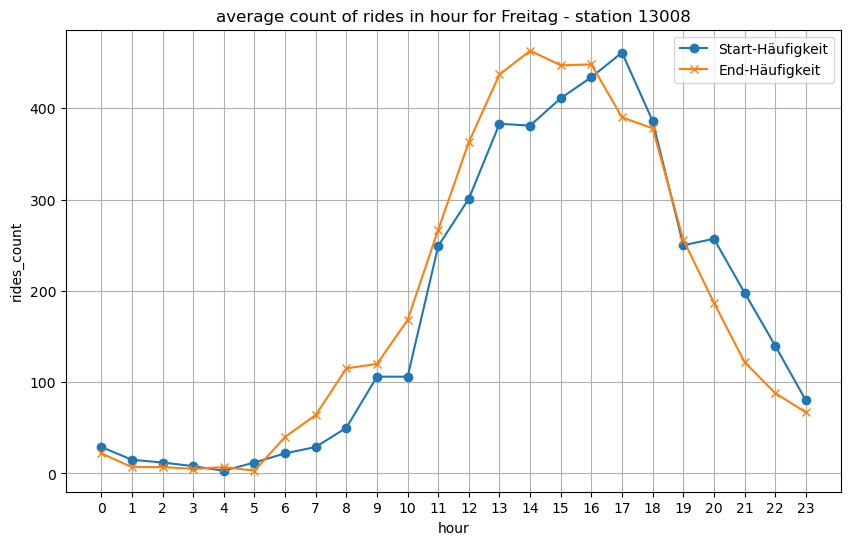

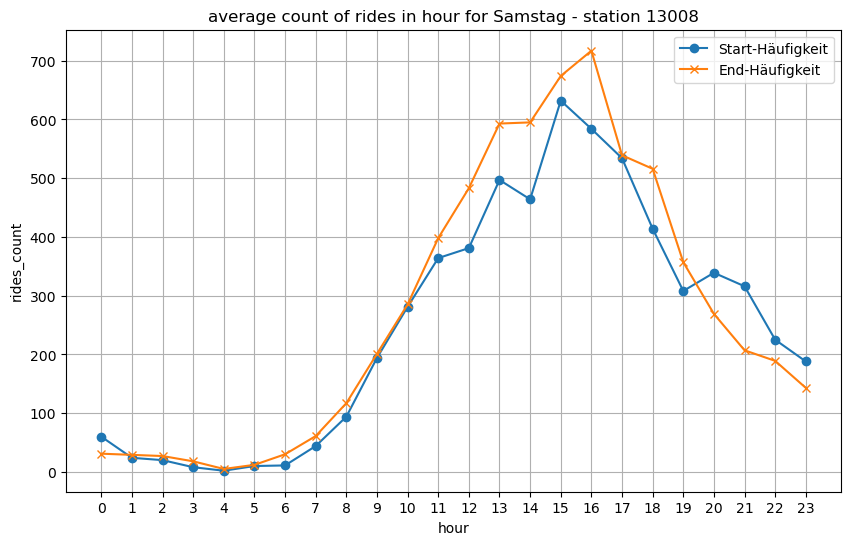

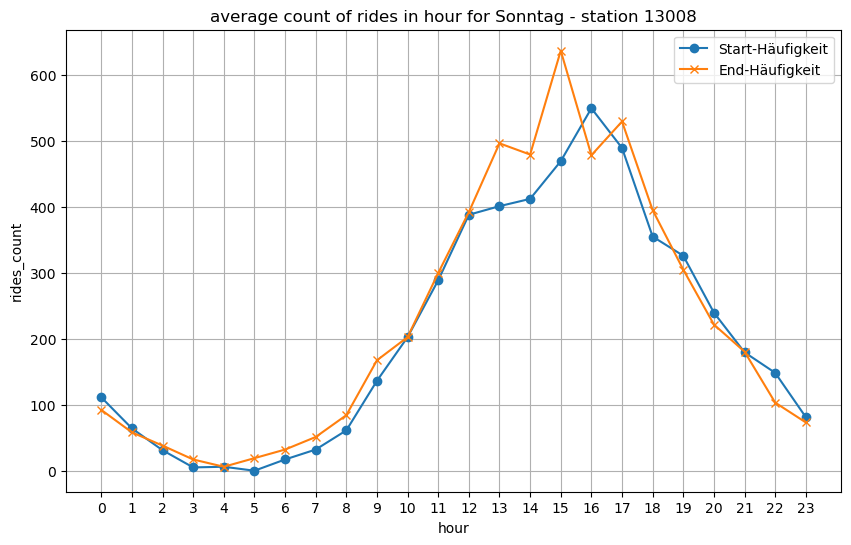

In [56]:
specific_station_id = '13008'

df_start_specific = df[df['start_station_id'] == specific_station_id]

# Filtern der Daten für eine spezifische Station als Endstation
df_end_specific = df[df['end_station_id'] == specific_station_id]

# Extrahieren der Stunden und Wochentage für Start- und Endzeiten
df_start_specific['start_hour'] = df_start_specific['started_at'].dt.hour
df_start_specific['start_weekday'] = df_start_specific['started_at'].dt.weekday
df_end_specific['end_hour'] = df_end_specific['ended_at'].dt.hour
df_end_specific['end_weekday'] = df_end_specific['ended_at'].dt.weekday

# Aggregation der Daten für Start- und Endzeiten
start_agg_specific = df_start_specific.groupby(['start_weekday', 'start_hour']).size().reset_index(name='start_count')
end_agg_specific = df_end_specific.groupby(['end_weekday', 'end_hour']).size().reset_index(name='end_count')

# Namen der Wochentage für die Titel der Schaubilder
weekday_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']

# Schaubilder für jeden Wochentag erstellen
for weekday in range(7):
    plt.figure(figsize=(10, 6))
    
    # Filtern der Daten für den spezifischen Wochentag
    start_specific_weekday = start_agg_specific[start_agg_specific['start_weekday'] == weekday]
    end_specific_weekday = end_agg_specific[end_agg_specific['end_weekday'] == weekday]
    
    # Plotten der durchschnittlichen Anzahl der Fahrten je Stunde für Start- und Endzeiten
    plt.plot(start_specific_weekday['start_hour'], start_specific_weekday['start_count'], label='Start-Häufigkeit', marker='o')
    plt.plot(end_specific_weekday['end_hour'], end_specific_weekday['end_count'], label='End-Häufigkeit', marker='x')
    
    plt.title(f'average count of rides in hour for {weekday_names[weekday]} - station {specific_station_id}')
    plt.xlabel('hour')
    plt.ylabel('rides_count')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
import folium

# Berechnung der Gesamtzahl der Fahrten pro Startstation
df_start = df.groupby('start_station_id').agg(
    start_lat=('start_lat', 'mean'),  # Mittlere Position für jede Station
    start_lng=('start_lng', 'mean'),
    start_rides=('ride_id', 'count')  # Anzahl der Fahrten von jeder Startstation
).reset_index()

# Berechnung der Gesamtzahl der Fahrten pro Endstation
df_end = df.groupby('end_station_id').agg(
    end_lat=('end_lat', 'mean'),  # Mittlere Position für jede Station
    end_lng=('end_lng', 'mean'),
    end_rides=('ride_id', 'count')  # Anzahl der Fahrten zu jeder Endstation
).reset_index()

def get_color(rides_count):
    if rides_count < 500:
        return 'green'
    elif rides_count < 1000:
        return 'blue'
    elif rides_count < 10000:
        return 'orange'
    elif rides_count < 20000:
        return 'yellow'
    else:
        return 'red'

# Erstellen der Karte mit einem mittleren Standort als Ausgangspunkt
map_start = folium.Map(location=[df_start['start_lat'].mean(), df_start['start_lng'].mean()], zoom_start=13)
map_end = folium.Map(location=[df_end['end_lat'].mean(), df_end['end_lng'].mean()], zoom_start=13)

# Hinzufügen der Startstationen zur Karte mit farbigen Kreismarkierungen
for idx, row in df_start.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=5,  # Einheitliche Größe für alle Kreise
        color=get_color(row['start_rides']),
        fill=True,
        fill_color=get_color(row['start_rides']),
        fill_opacity=0.7
    ).add_to(map_start)

# Hinzufügen der Endstationen zur Karte mit farbigen Kreismarkierungen
for idx, row in df_end.iterrows():
    folium.CircleMarker(
        location=[row['end_lat'], row['end_lng']],
        radius=5,  # Einheitliche Größe für alle Kreise
        color=get_color(row['end_rides']),
        fill=True,
        fill_color=get_color(row['end_rides']),
        fill_opacity=0.7
    ).add_to(map_end)

# Speichern der Karten als HTML-Dateien
map_start





In [54]:
map_end